In [1]:
from car_blur import find_car_on_image

In [2]:
IMG_PATH = '../data/car-segmentation/images/IMG_20201123_143405.png'
results = find_car_on_image(IMG_PATH)
results['mask']

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

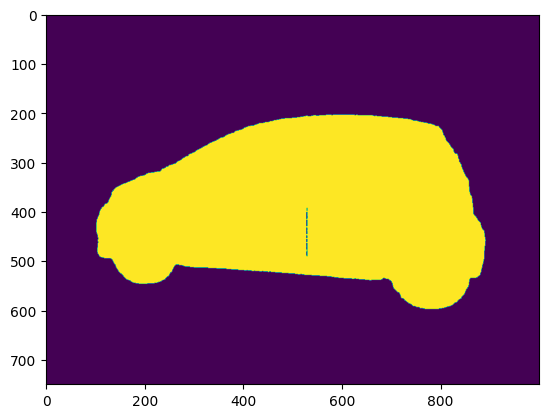

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
plt.imshow(results['mask'])

In [2]:
import os
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as T


class CarSegmentationDataset(Dataset):
    def __init__(self, image_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.image_paths = [
            os.path.join(image_dir, fname)
            for fname in os.listdir(image_dir)
            if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        mask = find_car_on_image(img_path)['mask']
        mask = Image.fromarray(mask.astype(np.uint8))

        if self.transform:
            image = self.transform(image)
        else:
            image = T.ToTensor()(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            mask = T.ToTensor()(mask) 

        return image, mask


In [3]:
from torch.utils.data import DataLoader

transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

dataset = CarSegmentationDataset(
    image_dir='../data/car-segmentation/images/',
    transform=transform,
    mask_transform=transform
)

dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [4]:
plt.imshow(dataset[10][0].permute(1, 2, 0))
plt.show()
plt.imshow(dataset[10][1].permute(1, 2, 0))

NameError: name 'plt' is not defined

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import wandb

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import torchmetrics
import segmentation_models_pytorch as smp


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b = self.bottleneck(self.pool4(e4))
        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return torch.sigmoid(self.final(d1))


class CarSegmentationModel(pl.LightningModule):
    def __init__(self, lr=1e-3, threshold=0.5):
        super().__init__()
        self.model = UNet()
        self.loss_fn = nn.BCELoss()
        self.lr = lr
        self.threshold = threshold

        # Метрики
        self.val_iou = torchmetrics.classification.BinaryJaccardIndex(threshold=threshold)
        self.val_acc = torchmetrics.classification.BinaryAccuracy(threshold=threshold)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        imgs, masks = batch
        preds = self(imgs)
        loss = self.loss_fn(preds, masks)
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, masks = batch
        preds = self(imgs)

        loss = self.loss_fn(preds, masks)

        iou = self.val_iou(preds, masks.int())
        acc = self.val_acc(preds, masks.int())

        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_iou", iou, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    

class CarSegmentationModel(pl.LightningModule):
    def __init__(self, lr=1e-3, threshold=0.5):
        super().__init__()
        self.save_hyperparameters()

        self.model = smp.Unet(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
            activation=None
        )

        self.loss_fn = nn.BCEWithLogitsLoss()  # используем BCE с логитами
        self.threshold = threshold

        self.val_iou = torchmetrics.classification.BinaryJaccardIndex(threshold=threshold)
        self.val_acc = torchmetrics.classification.BinaryAccuracy(threshold=threshold)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        imgs, masks = batch
        logits = self(imgs)
        loss = self.loss_fn(logits, masks)
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, masks = batch
        logits = self(imgs)
        loss = self.loss_fn(logits, masks)

        preds = torch.sigmoid(logits)
        iou = self.val_iou(preds, masks.int())
        acc = self.val_acc(preds, masks.int())

        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_iou", iou, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


def get_dataloaders(batch_size=8, image_dir="../data/car-segmentation/images/"):
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor()
    ])
    dataset = CarSegmentationDataset(image_dir, transform, transform)
    val_split = int(0.8 * len(dataset))
    train_ds, val_ds = torch.utils.data.random_split(dataset, [val_split, len(dataset) - val_split])
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(val_ds, batch_size=batch_size)
    )


def main():
    wandb.init(project="car-segmentation-unet", name="UNet+SAM", sync_tensorboard=True)
    wandb_logger = WandbLogger(log_model="all")
    
    train_loader, val_loader = get_dataloaders()

    model = CarSegmentationModel()

    checkpoint = ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min")
    
    trainer = pl.Trainer(
        max_epochs=20,
        logger=wandb_logger,
        callbacks=[checkpoint],
        accelerator="auto"
    )
    
    try:
        trainer.fit(model, train_loader, val_loader)
    except:
        pass
    finally:
        wandb.finish()


if __name__ == "__main__":
    main()


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: venbiess (venbiess-hse). Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\User\anaconda3\envs\gpu_env\lib\site-packages\pytorch_lightning\loggers\wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params | Mode 
-------------------------------------------------------
0 | model   | Unet               | 24.4 M | train
1 | loss_fn | BCEWithLogitsLoss  | 0      | train
2 | val_iou | BinaryJaccardIndex | 0      | train
3 | val_acc | BinaryAccuracy     | 0      | train
-------------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.745    Total estimated model params size (MB)
191       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\User\anaconda3\envs\gpu_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\User\anaconda3\envs\gpu_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\User\anaconda3\envs\gpu_env\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

C:\Users\User\anaconda3\envs\gpu_env\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=20` reached.


In [16]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import wandb

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import torchmetrics
import segmentation_models_pytorch as smp

class CarSegmentationModel(pl.LightningModule):
    def __init__(self, lr=1e-3, threshold=0.5):
        super().__init__()
        self.save_hyperparameters()

        self.model = smp.Unet(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=3,
            classes=1,
            activation=None
        )

        self.loss_fn = nn.BCEWithLogitsLoss()  # используем BCE с логитами
        self.threshold = threshold

        self.val_iou = torchmetrics.classification.BinaryJaccardIndex(threshold=threshold)
        self.val_acc = torchmetrics.classification.BinaryAccuracy(threshold=threshold)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        imgs, masks = batch
        logits = self(imgs)
        loss = self.loss_fn(logits, masks)
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, masks = batch
        logits = self(imgs)
        loss = self.loss_fn(logits, masks)

        preds = torch.sigmoid(logits)
        iou = self.val_iou(preds, masks.int())
        acc = self.val_acc(preds, masks.int())

        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_iou", iou, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


PATH = ('lightning_logs/8f8nyjrx/checkpoints/epoch=19-step=420.ckpt')
# model = CarSegmentationModel()
model = CarSegmentationModel.load_from_checkpoint(PATH)

In [19]:
dataset[0]

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
       

In [27]:
model(dataset[0][0].to('cuda').unsqueeze(0)).max()

tensor(-3.8581, device='cuda:0', grad_fn=<MaxBackward1>)

In [28]:
dataset[0][0]

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])